In [1]:
from argparse import ArgumentParser
import time

import matplotlib.pyplot as plt
import numpy as np
import sympy

from devito import Grid, Eq, Operator, TimeFunction, solve
from devito.logger import log

In [2]:
def execute_devito(ui, spacing=0.01, a=0.5, timesteps=50):
    """Execute diffusion stencil using the devito Operator API."""
    nx, ny = ui.shape
    dx2, dy2 = spacing**2, spacing**2
    dt = dx2 * dy2 / (2 * a * (dx2 + dy2))
    # Allocate the grid and set initial condition
    # Note: This should be made simpler through the use of defaults
    grid = Grid(shape=(nx, ny))
    u = TimeFunction(name='u', grid=grid, time_order=1, space_order=2)
    u.data[0, :] = ui[:]
    # Derive the stencil according to devito conventions
    eqn = Eq(u.dt, a * (u.dx2 + u.dy2))
    stencil = solve(eqn, u.forward)
    
    # bc1: we are bumping water out of the well
    bc1 = Eq(u[1, nx//2, ny//2], 0)
    
    # bc2: Neumann boundary condition
    # create boundary condition
    # bc = [Eq(u[timesteps, 0,    :],    u[timesteps, 1,    :])]
    # bc+= [Eq(u[timesteps, nx-1, :],    u[timesteps, nx - 2, :])]
    # bc+= [Eq(u[timesteps, :, ny-1],    u[timesteps, :, ny - 2])]
    # bc+= [Eq(u[timesteps, :,    0],    u[timesteps, :,    1])]
    
    bc = [Eq(u[1, 0,    :],    u[1, 1,    :])]
    bc+= [Eq(u[1, nx-1, :],    u[1, nx - 2, :])]
    bc+= [Eq(u[1, :, ny-1],    u[1, :, ny - 2])]
    bc+= [Eq(u[1, :,    0],    u[1, :,    1])]
    
    op = Operator([Eq(u.forward, stencil), bc1, bc])

    # Execute the generated Devito stencil operator
    tstart = time.time()
    op.apply(u=u, t=timesteps, dt=dt)
    runtime = time.time() - tstart
    log("Devito: Diffusion with dx=%0.4f, dy=%0.4f, executed %d timesteps in %f seconds"
        % (spacing, spacing, timesteps, runtime))
    return u.data[1, :], runtime

In [3]:
# init grid
nx, ny = 100, 100
nt = 50
pres = 100
tm = 0
grid = np.ones((nx, ny)) * pres
data = np.zeros((nx, ny, nt))
grid[nx//2,ny//2] = 0
data[:,:,0] = grid

In [5]:
for iter in range(nt - 1): 
    data[:, :, iter + 1], tm = execute_devito(data[:,:,iter], timesteps=1)

AttributeError: 'NoneType' object has no attribute 'is_Float'

In [9]:
import matplotlib.pyplot as plt

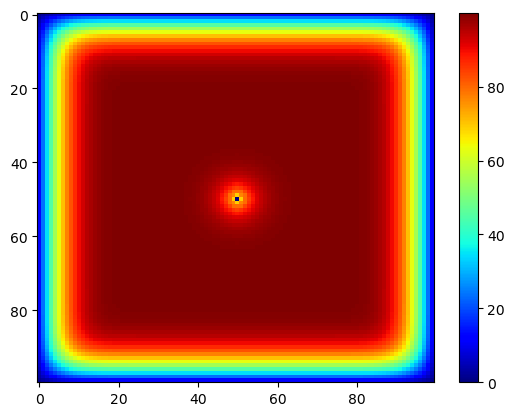

In [10]:
plt.figure()
plt.imshow(data[:,:,30], aspect='auto', cmap='jet')
plt.colorbar()
plt.show()

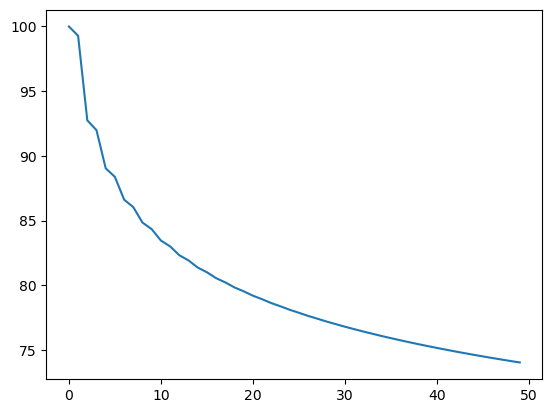

In [11]:
plt.figure()
plt.plot(data[49,49,:])
plt.show()